# Binary Classification: Normal vs Electrolarynx

## Installing needed modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
### Training / Fitting / Optimizing Model #####
test_size = 0.2
epochs    = 50
batch_size= 40
#Justification for optimizer chosen: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/ 
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optimizer = SGD(learning_rate=0.001,momentum =0.9)

## Helper Functions

In [3]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    features = []
    
    audio_data, sample_rate = librosa.load(file_name)
    #stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40
    
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    #features.extend(chroma) # 12 = 52
    
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180
    
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #features.extend(contrast) # 7 = 187

# More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [4]:
def display_wav(file = None):
    # Displays comparison of loading a wav file via librosa vs via scipy
    if not file:
        print("No wav file to display")
        return
    librosa_load, librosa_sampling_rate = librosa.load(file)
    scipy_sampling_rate, scipy_load = wavfile.read(file)
    print('original sample rate:',scipy_sampling_rate)
    print('converted sample rate:',librosa_sampling_rate)
    print('\n')
    print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
    print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_load)
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_load)

In [5]:
def load_all_wav_files(files):
    '''
    Returns two numpy array
    The first is a numpy array containing each audio's numerical features - see extract_features()
    The second numpy array is the array *STRING* of the label.
    (The array indexes align up between the two arrays. data[idx] is classified as labels[idx]) 
    '''
    one_file = None
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
#SHORTCUT
# This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
#             if len(all_data) > 0: 
#                 break
#END SHORTCUT
    for idx, file in enumerate(files):
        if file.find('Normal')!=-1:
            features = extract_features(file)
            label = "normal"
            all_data.append(features)
            all_labels.append(label)
#                     display_wav(fname)
#                     break
        if file.find('Electrolarynx')!=1:
            features = extract_features(file)
            label = "electrolarynx"
            all_data.append(features)
            all_labels.append(label)
    return np.array(all_data), np.array(all_labels)

In [6]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)
#     print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
#     print(corr['SalePrice'].sort_values(ascending = False)[-5:])

In [7]:
def plot_history(history = None):
    # Plots accuracy & loss versus epochs
    if not history:
        print("No history to plot")
        return
    fig = plt.figure(figsize=(10,8))
#     fig = plt.figure(figsize=(20,16))
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.axis([0,90,0,1.1])
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

## Creating the Data

In [8]:
#creating the list of filenames
import glob
#change the file path to where you have stored the normal_larynx files
DATA_DIR = glob.glob('/scratch/sg2dk/Capstone_Part2/*/Normal/*_transcribed.wav')
normalFiles=[]
# Shuffle

for flist in DATA_DIR:
    normalFiles.append(flist)
    ipd.Audio(flist)
print(normalFiles)

['/scratch/sg2dk/Capstone_Part2/Participant1/Normal/20.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/15.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/23.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/18.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/16.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/14.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/13.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/21.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/17.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/19.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Normal/22.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant5/Normal/98.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant5/Normal/96.mp4_transcribed.wav', '/scratch/s

In [9]:
#change the file path in data dir to where your electrolaynx files are stored 
DATA_DIR = glob.glob('/scratch/sg2dk/Capstone_Part2/*/Electrolarynx/*_transcribed.wav')
filenames=[]
# Shuffle

for flist in DATA_DIR:
    filenames.append(flist)
print(filenames)

['/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/12.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/6.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/8.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/11.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/5.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/2.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/9.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/7.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/3.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/4.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/10.mp4_transcribed.wav', '/scratch/sg2dk/Capstone_Part2/Participant5/Electrolarynx/85.mp4_transcribed.wav', '/scratch/s

In [10]:
#combining all the files into one list
allFiles = np.concatenate([filenames,normalFiles])
print(allFiles)

['/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/12.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/6.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/8.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/11.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/5.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/2.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/9.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/7.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/3.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/4.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant1/Electrolarynx/10.mp4_transcribed.wav'
 '/scratch/sg2dk/Capstone_Part2/Participant5/Electrolarynx/85.mp4_transcribed.wav'
 '/scratch/s

## Starting to Create the Model

In [11]:
all_data = np.array([])
all_labels_list = []
all_labels = np.array([])
one_file = None

all_data, all_labels= load_all_wav_files(allFiles)


In [12]:
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)

(152, 168)
['electrolarynx', 'normal']


In [13]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=test_size,random_state=0, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(121, 168)
(121,)
(31, 168)
(31,)


In [14]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU


#Trying to do a binary classification:https://www.pluralsight.com/guides/deep-learning-model-perform-binary-classification
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu',input_shape=(x_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#Plot summary
model.summary()

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
#                         shuffle=True,
                    verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                10816     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 - 0s - loss: 2.9592 - accuracy: 0.4463 - val_loss: 1.2598 - val_accuracy: 0.7419
Epoch 2/50
4/4 - 0s - loss: 1.8729 - accuracy: 0.6446 - val_loss: 1.1985 - val_accuracy: 0.6129
Epoch 3/50
4/4 - 0s - loss: 0.9368 - accuracy: 0.6942 - val_loss: 2.7769 - val_accuracy: 0.5806
Epoch 4/50
4/4 - 0s - loss: 1.7227 - accuracy: 0.6529 - val_loss: 1.6506 - val_accuracy: 0.580

In [15]:
score_train = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_train[1])
print("Training Cross Entropy: %.2f" % score_train[0])

score_test = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

Training Accuracy:  0.6859503984451294
Training Cross Entropy: 0.59
Testing Accuracy:  0.6129032373428345
Testing Cross Entropy: 0.73


## Plotting the Results

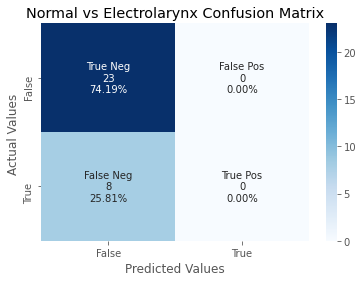

In [16]:
y_pred_percentages = model.predict(x_test) # predicted percentages

y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction

#Plotting the confusion matrix:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
ax.set_title('Normal vs Electrolarynx Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix and save it as png
plt.savefig("ConfusionMatrixBinary.png")

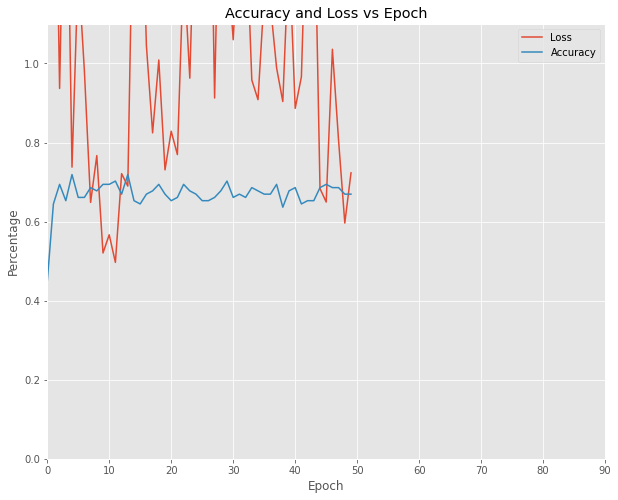

In [17]:
plot_history(history)

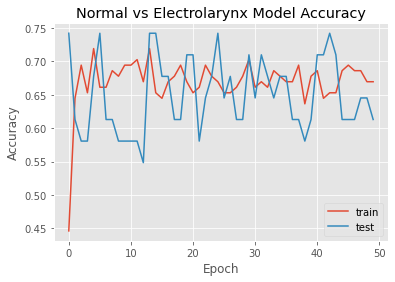

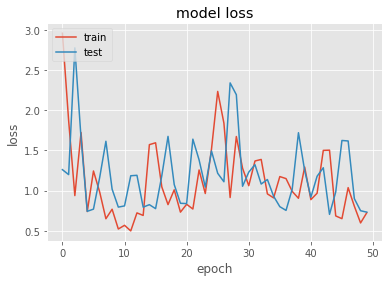

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Normal vs Electrolarynx Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig("NormalElectroAccu.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#32, 32 lstm, w/ mel, chroma, zcr, mfcc, sp_centroid, sp_rolloff
#sgd 0.01
#***